## Домашнее задание

Приложен [ноутбук](https://colab.research.google.com/drive/1WuyxuftSjZpGICdN2nq612y2WOD5L85Z?usp=sharing), в котором реализованы функции для генерации из большого датасета в меньшую его копию. Вам нужно сделать следующее: 

1. Сгенерировать меньший датасет из 8-10 классов движения
2. Обучить уже существующую модель (предварительно проанализировав, какие параметры модели нужно изменить)
3. Изменить модель: посмотреть зависимость от количества LSTM модулей в модели  
4. *Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество.

## Дополнительные материалы


1. [Статья с которой все началось (2017)](https://arxiv.org/abs/1706.03762)  
2. [Реализация модели из статьи выше на pytorch](https://www.youtube.com/watch?v=U0s0f995w14)  
3. [Короткое видео где все лаконично объясняется](https://www.youtube.com/watch?v=TQQlZhbC5ps)  
4. [Видео по длинее](https://www.youtube.com/watch?v=S27pHKBEp30)    
5. [Статья на русском и на tf](https://www.tensorflow.org/text/tutorials/transformer)   
6. [Статья модели улучшенного трансформера (2018)](https://arxiv.org/abs/1808.03867)  
7. [Статья-вики](https://ru.wikipedia.org/wiki/%D0%A2%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80_(%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F))  
8. [Библиотека для pytorch](https://huggingface.co/transformers/)  
9. [Пример применения трансформера в качестве классификатора](https://github.com/lucidrains/vit-pytorch)
10. [Прикладное машинное обучение 4. Self-Attention. Transformer overview](https://youtu.be/UETKUIlYE6g)
11. [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

[Machine Learning Toolkits - Awesome ML Resources](https://www.kaggle.com/arunkumarramanan/machine-learning-toolkits-awesome-ml-resources)

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torch import optim
import time
import math


from IPython import display

# from torch import optim
# import time
# import math

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [2]:
np.random.seed(11)

In [3]:
skeletons = pd.read_csv("new_skels.csv")

In [4]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,0.216129,0.185681,3.767784,0.228515,0.437528,3.691366,0.239707,0.684526,3.604562,0.209585,...,-0.063488,0.382279,3.528925,0.179688,0.384653,3.434258,0.232128,0.364689,3.432100,0
1,0.205810,0.192052,3.810989,0.213430,0.442297,3.726759,0.221343,0.687635,3.632531,0.190760,...,0.218939,0.449263,3.478400,-0.009107,0.534840,3.517180,0.053082,0.530157,3.493546,1
2,0.396609,0.006900,4.115710,0.376591,0.210750,4.021791,0.357572,0.411765,3.918263,0.338087,...,0.219130,0.500625,3.811604,0.367042,0.504430,3.772113,0.398096,0.470677,3.749125,2
3,0.400450,0.041164,4.123791,0.368277,0.239312,4.052476,0.341028,0.437555,3.973147,0.391725,...,0.205729,-0.012569,3.927667,0.707330,0.018093,3.901483,0.660581,-0.015222,3.880133,2
4,0.408567,0.006618,4.112436,0.384638,0.205177,4.015311,0.360655,0.400779,3.907876,0.341943,...,0.196591,0.426323,3.807375,0.316770,0.436582,3.704146,0.327285,0.407917,3.670400,3


In [5]:
LABELS = {               # классы которые будем использовать 
          3: 'drop',     # для обучения, полный список представлен тут https://github.com/shahroudy/NTURGB-D
          8: 'reading',   
          0: 'wear on glasses',
          2: 'take off glasses',
          1: 'put on a hat/cap',
          5: 'take off a hat/cap',
          9: 'jump up',
          7: 'falling',
          6: 'walking towards each other',
          4: 'walking apart from each other',
         }

In [6]:
skeletons['labels'].value_counts()

1    121
2    121
5    121
0    120
3    120
4    120
6    120
7    120
8    120
9    120
Name: labels, dtype: int64

In [7]:
skeletons.shape

(1203, 3376)

### Dataloader

In [8]:
3375 / (25 * 3)

45.0

In [9]:
class SkeletonDataset(Dataset):
    def __init__(self, file_path,frames_count=45, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.frames_count=frames_count

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.frames_count, 25 * 3)
        label = self.labels[idx]
        
        if self.transform != None:
            item = transform(item)

        return (item, label) 

In [10]:
frames = 45

dataset = SkeletonDataset(file_path="new_skels.csv",frames_count=frames, transform=None)

In [11]:
dataset.data.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,0.216129,0.185681,3.767784,0.228515,0.437528,3.691366,0.239707,0.684526,3.604562,0.209585,...,-0.063488,0.382279,3.528925,0.179688,0.384653,3.434258,0.232128,0.364689,3.432100,0
1,0.205810,0.192052,3.810989,0.213430,0.442297,3.726759,0.221343,0.687635,3.632531,0.190760,...,0.218939,0.449263,3.478400,-0.009107,0.534840,3.517180,0.053082,0.530157,3.493546,1
2,0.396609,0.006900,4.115710,0.376591,0.210750,4.021791,0.357572,0.411765,3.918263,0.338087,...,0.219130,0.500625,3.811604,0.367042,0.504430,3.772113,0.398096,0.470677,3.749125,2
3,0.400450,0.041164,4.123791,0.368277,0.239312,4.052476,0.341028,0.437555,3.973147,0.391725,...,0.205729,-0.012569,3.927667,0.707330,0.018093,3.901483,0.660581,-0.015222,3.880133,2
4,0.408567,0.006618,4.112436,0.384638,0.205177,4.015311,0.360655,0.400779,3.907876,0.341943,...,0.196591,0.426323,3.807375,0.316770,0.436582,3.704146,0.327285,0.407917,3.670400,3


In [12]:
dataset.data.loc[(dataset.data['labels']==9)].head(5)

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
12,0.274456,0.185194,3.848278,0.289456,0.441725,3.762464,0.302607,0.693304,3.665846,0.277918,...,0.187733,0.050407,3.665154,0.484130,-0.155524,3.925122,0.474283,-0.148092,3.917333,9
13,0.385028,0.057802,3.950152,0.378339,0.237974,3.826122,0.368662,0.423132,3.686128,0.352751,...,1.785242,0.036183,3.732643,1.749466,0.165231,3.723315,1.719761,0.240731,3.743500,9
26,0.137127,0.119095,3.702249,0.107716,0.395003,3.634770,0.079814,0.665783,3.555674,0.077476,...,-0.223150,0.100210,3.688111,-0.367100,-0.055086,3.661322,-0.331527,-0.011565,3.662412,9
27,-0.375734,0.082200,3.780461,-0.426007,0.368695,3.699091,-0.474193,0.649755,3.607331,-0.519642,...,-2.022615,0.013208,3.721229,-2.187263,-0.058521,3.766090,-2.164335,-0.040978,3.757461,9
39,0.566663,0.058642,3.460102,0.584659,0.340276,3.395781,0.599430,0.615911,3.320545,0.597485,...,1.075125,-0.069719,3.256750,1.156460,0.104732,3.489076,1.148831,0.110541,3.474906,9


In [13]:
skel, lab = dataset.__getitem__(39)
skel, lab = dataset[39]

In [14]:
LABELS[lab]

'jump up'

In [15]:
skel.shape

(45, 75)

In [16]:
skels_for_draw = skel.reshape(-1, 25, 3)

### Немного визуализации данных

In [17]:
# !pip install celluloid

100%|██████████| 45/45 [00:05<00:00,  8.26it/s]


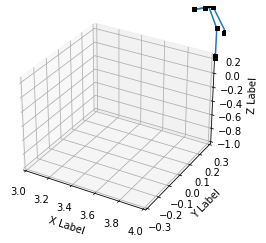

In [18]:
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D  
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from matplotlib import pyplot as plt
from celluloid import Camera


bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25), (25, 12)
)

from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

camera = Camera(fig)

for i in tqdm(range(0, 45)):
   
    for_draw = skels_for_draw[i]

    for pair in bone_pairs:
        xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
        ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
        zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

        line = plt3d.art3d.Line3D(zs, xs, ys)
        ax.add_line(line)

    for x,y,z in for_draw:
        ax.scatter(z, x, y, color='black', marker='s')

        ax.set_ylim((-0.3, 0.3))
        ax.set_zlim((-1.0, 0.25))
        ax.set_xlim((3.0, 4.0))


        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
    
    camera.snap()

animation = camera.animate()
animation.save(f'action_{LABELS[lab]}.gif', writer='pillow')

<img src='action_jump up.gif'>

### 2. Обучить уже существующую модель (предварительно проанализировав, какие параметры модели нужно изменить)

Видно, что на текущих параметрах модели наболюдается очень сильное переобучение.

Попробуем стабилизировать нейронную сеть засчет добаления к-ва слоев. 

можно попробовать уменьшить к-во LSTM-слоев.


Выравняли размер батча для тренировочной и тестовой выборки. = 16

In [45]:
train_len = int(0.75*len(dataset))

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [train_len, len(dataset) - train_len]
)
train_loader = DataLoader(
    train_dataset,
    batch_size=16, 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=False
)

### Построим Нейронную сеть.

In [46]:
class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        """
        input_dim: кол-во признаков, которые поступают на вход нейронной сети
        hidden_dim: кол-во нейронов на скрытом слое (кол-во признаков
                    на скрытом состоянии реккурентного слоя)
        output_dim: выход нейронной сети
        layer_num: кол-во реккурентных слоев , если layer_num=2, то настакается
                   два слоя LSTM, где второй LSTM будет принимать выходы первого
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(
            input_dim,
            hidden_dim,
            layer_num,
            batch_first=True
        )
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(
            hidden_dim,
            output_dim
        )
        
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1])
        return out

In [47]:
n_hidden = 128
n_joints = 25 * 3
n_categories = len(LABELS)
n_layer = 2

rnn = LSTM_net(
    n_joints,
    n_hidden,
    n_categories,
    n_layer
)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [48]:
def class_from_output(output):
    top_n, top_i = output.topk(1)
    class_i = top_i[0].item()
    return LABELS[class_i], class_i

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {int(s)}s'

In [49]:
def calc_accuracy(model, test_loader):
    total = 0
    right = 0
    counter = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            counter = counter + 1
            inputs, labels = data[0].to(device), data[1].to(device)  
            output = model(inputs.float())
            guess, guess_i = class_from_output(output)
            true = LABELS[int(labels[0])]
            
            if guess == true:
                right = right + 1

    accuracy = (100 * right / counter)
    # print('Accuracy of the network:', accuracy)
    return accuracy

In [50]:
def fit(model, train_loader, test_loader, optimizer, epoch_count=100):
    criterion = nn.CrossEntropyLoss()
    min_loss = 20 # Цифру поставил от балды :)
    train_losses = []
    test_losses = []
    start = time.time()
    counter = 0

    for epoch in range(epoch_count):  
        current_loss = 0
        running_loss = 0.0
        total = 0
        sum_loss = 0.0

        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            len_batch = labels.shape[0]
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs.float())
            train_loss = criterion(output, labels)
            train_loss.backward()
            optimizer.step() 

            total += len_batch
            sum_loss += train_loss.item()

            pred_label = LABELS[int(labels[0])]

            if counter % 500 == 0:
                guess, guess_i = class_from_output(output)
                correct = '✓' if guess == pred_label else f'✗ ({pred_label})'
                print(f'epoch : {epoch} iter : {i} ({time_since(start)})', end=' ')
                print(f'{train_loss:.4f} / {guess} {correct}')

            counter = counter + 1

        train_losses.append(sum_loss / total)
    #==========================================================================================================
        model.eval()
        val_total = 0
        val_sum_loss = 0
        for i, (inputs, labels) in enumerate(test_loader, 0):
            len_batch = labels.shape[0]
            inputs, labels = inputs.to(device), labels.to(device)
            
            output = model(inputs.float())
            val_loss = criterion(output, labels)

            val_total += len_batch
            val_sum_loss += val_loss.item()
            
        test_losses.append(val_sum_loss / val_total)
        # do something (save model, change lr, etc.)
        if min_loss > test_losses[-1]:
            min_loss = test_losses[-1]
            torch.save(model, './best_model.pth')
            # print('Model saved!')
        
    return train_losses, test_losses

In [51]:
epoch = 150
learning_rate = 0.0003

In [52]:
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

train_losses, valid_losses =  fit(rnn, train_loader, test_loader, optimizer=optimizer, epoch_count=epoch)
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

epoch : 0 iter : 0 (0m 0s) 2.3012 / jump up ✗ (take off glasses)
epoch : 9 iter : 23 (0m 21s) 2.4301 / take off glasses ✗ (put on a hat/cap)
epoch : 18 iter : 46 (0m 42s) 1.0371 / take off a hat/cap ✗ (walking apart from each other)
epoch : 28 iter : 16 (1m 6s) 0.6562 / put on a hat/cap ✓
epoch : 37 iter : 39 (1m 31s) 1.0167 / falling ✓
epoch : 47 iter : 9 (2m 8s) 0.6453 / jump up ✓
epoch : 56 iter : 32 (2m 45s) 0.5211 / put on a hat/cap ✗ (reading)
epoch : 66 iter : 2 (3m 22s) 0.4348 / drop ✗ (walking apart from each other)
epoch : 75 iter : 25 (3m 59s) 0.6454 / take off glasses ✓
epoch : 84 iter : 48 (4m 35s) 0.4619 / walking towards each other ✓
epoch : 94 iter : 18 (5m 13s) 0.4147 / drop ✗ (put on a hat/cap)
epoch : 103 iter : 41 (5m 49s) 0.3253 / reading ✓
epoch : 113 iter : 11 (6m 26s) 0.3266 / wear on glasses ✓
epoch : 122 iter : 34 (7m 3s) 0.1379 / wear on glasses ✓
epoch : 132 iter : 4 (7m 40s) 0.0812 / jump up ✓
epoch : 141 iter : 27 (8m 16s) 0.1703 / walking towards each oth

accuracy:  83.33333333333333


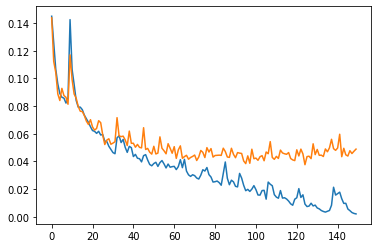

In [53]:
print('accuracy: ',calc_accuracy(best_model, test_loader))

plt.plot(list(range(0-, len(train_losses))), train_losses)
plt.plot(list(range(0, len(valid_losses))), valid_losses)
plt.show()

Видно, что на текущих параметрах модели наболюдается очень сильное переобучение.

Попробуем стабилизировать нейронную сеть засчет добаления к-ва слоев. 

можно попробовать уменьшить к-во LSTM-слоев.

### 3. Изменить модель: посмотреть зависимость от количества LSTM модулей в модели  

Установи к-во эпох = 80. после этого к-во начинает падать, поэтому дальнейшее обучение не имеет смысла. 

Определим число эпох. Посмотрим, в какой момент модель начнет переобучаться. 

In [25]:
# Создадаим словарик в котором будем хранить список изменений.

model_results = []
train_losses_list = []
valid_losses_list = []

n_hiddens = [64, 128, 256]
n_layers = [1, 2 ,3]
n_joints = 25 * 3
n_categories = len(LABELS)
epoch = 80

for n_hidden in n_hiddens:
    for n_layer in n_layers:
        
        print('n_hidden: ',n_hidden,'n_layer: ',n_layer)
        model_result = {}
        model_result['n_hidden'] = n_hidden
        model_result['n_layer'] = n_layer

        rnn = LSTM_net(
            n_joints,
            n_hidden,
            n_categories,
            n_layer
        )
        rnn.to(device)

        optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

        train_losses, valid_losses =  fit(rnn, 
                                          train_loader,
                                          test_loader,
                                          optimizer=optimizer,
                                          epoch_count=epoch)
        
        train_losses_list.append(train_losses)
        valid_losses_list.append(valid_losses)

        
        best_model = torch.load('./best_model.pth')

        model_result['accuracy'] = calc_accuracy(best_model, test_loader)
        
        model_results.append(model_result)

        display.clear_output(wait=False)

In [26]:
df = pd.DataFrame(model_results)
df

,n_hidden,n_layer,accuracy
0,64,1,78.947368
1,64,2,68.421053
2,64,3,57.894737
3,128,1,57.894737
4,128,2,68.421053
5,128,3,52.631579
6,256,1,84.210526
7,256,2,68.421053
8,256,3,73.684211


#### Графики обучения.

n_hidden:64.0, n_layer:1.0, accuracy:78.947


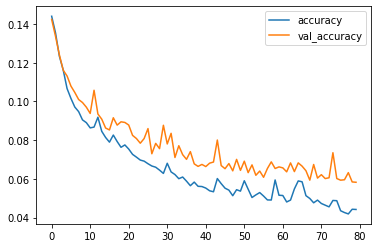

n_hidden:64.0, n_layer:2.0, accuracy:68.421


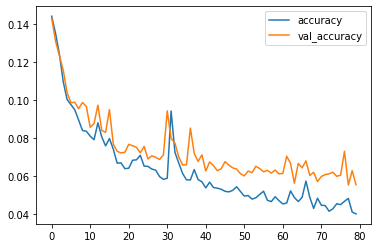

n_hidden:64.0, n_layer:3.0, accuracy:57.895


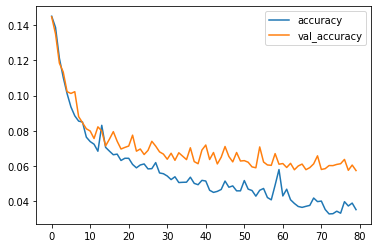

n_hidden:128.0, n_layer:1.0, accuracy:57.895


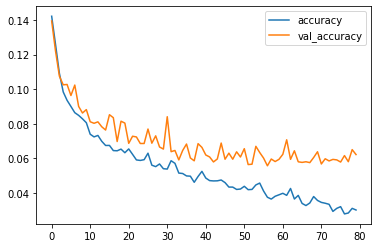

n_hidden:128.0, n_layer:2.0, accuracy:68.421


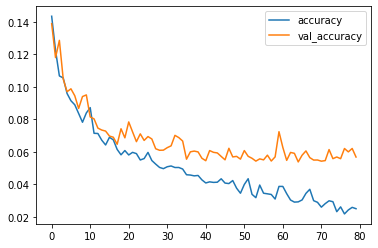

n_hidden:128.0, n_layer:3.0, accuracy:52.632


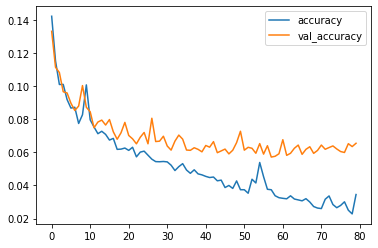

n_hidden:256.0, n_layer:1.0, accuracy:84.211


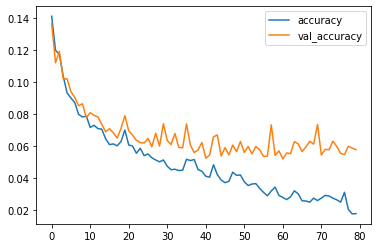

n_hidden:256.0, n_layer:2.0, accuracy:68.421


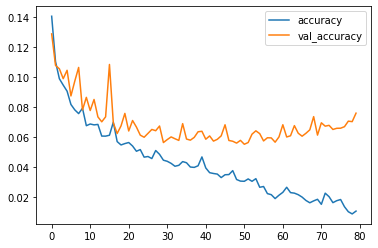

n_hidden:256.0, n_layer:3.0, accuracy:73.684


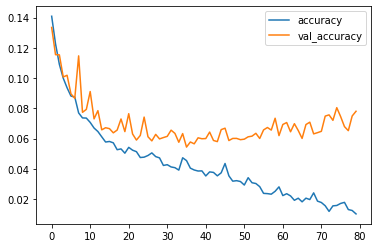

In [28]:
for i in range(len(df)):
    print(f'n_hidden:{df.iloc[i].n_hidden}, n_layer:{df.iloc[i].n_layer}, accuracy:{df.iloc[i].accuracy:.3f}')
    plt.plot(list(range(0, len(train_losses_list[i]))), train_losses_list[i],label = 'accuracy')
    plt.plot(list(range(0, len(valid_losses_list[i]))), valid_losses_list[i], label = 'val_accuracy')
    plt.legend()
    plt.show()

### 4. *Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество.

### Результаты! 

В общем, я проверил несколько вариантов и вот такой результат у меня получилось.

<img src='Model_Results.png'>

Что любопытно, при запуске, модели каждый раз показывали разные результаты, достаточно сильно отличающиеся друг от друга.

Отсюда как раз возникает проблемма с тем, что в таких условиях достаточно сложно определить, какой вариант лучше.

Но, в целом закономерность прослеживается. При малом к-ве фреймов модель ведет себя не стабильно. В одном прогоне она может дать очень хороший результат, а в следующем очень низкий. 
Поэтому, все же лучше устанавливать к-во фреймов по больше. Скажем 60-70. На этом значении мне кажется модель будет показывать более менее стабильный результат.   


**Юлия! А, как дела обстоят на самом деле? Исходя из вашего опыта.**

Обернем все методы в один цикл

In [37]:
n_hidden = 128
n_layer = 2
n_joints = 25 * 3
epoch = 80    
learning_rate = 0.0003

model_results = []
train_losses_list = [] 
valid_losses_list = []
n_categories = len(LABELS)

In [38]:
frame_counts = [10,17,24,45,60]

for frames in frame_counts:
    
# Загрузка датасета. 
    dataset = SkeletonDataset(file_path=f"skels_frame_{frames}.csv", 
                              frames_count=frames,
                              transform=None)
    
    train_len = int(0.75*len(dataset))
    
    train_dataset, test_dataset = torch.utils.data.random_split(
                                   dataset,
                                   [train_len, len(dataset) - train_len]
                                  )
# DataLoader
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
#======================================================================================
    print('frames: ',frames)
    
    model_result = {}
    model_result['frames'] = frames
# NN init.
    rnn = LSTM_net(
        n_joints,
        n_hidden,
        n_categories,
        n_layer
    )
    rnn.to(device)

    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
    
# Fit model.
    train_losses, valid_losses =  fit(rnn, 
                                      train_loader,
                                      test_loader,
                                      optimizer=optimizer,
                                      epoch_count=epoch)
    
    train_losses_list.append(train_losses)
    valid_losses_list.append(valid_losses)

    
    best_model = torch.load('./best_model.pth')

    model_result['accuracy'] = calc_accuracy(best_model, test_loader)
    
    model_results.append(model_result)

    display.clear_output(wait=False) # После каждого прохода очищаем поле вывода.

In [39]:
df = pd.DataFrame(model_results)
df

,frames,accuracy
0,10,75.000000
1,17,57.894737
2,24,52.631579
3,45,68.421053
4,60,66.666667


frames:10.0, accuracy:75.000


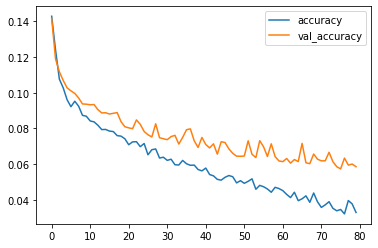

frames:17.0, accuracy:57.895


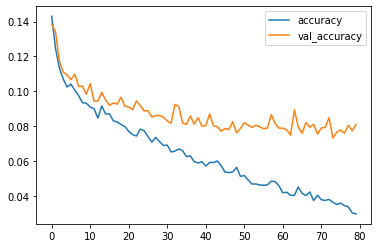

frames:24.0, accuracy:52.632


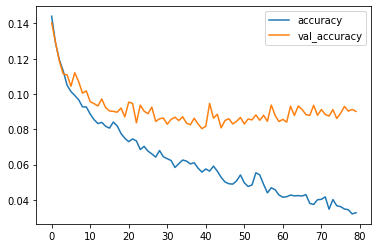

frames:45.0, accuracy:68.421


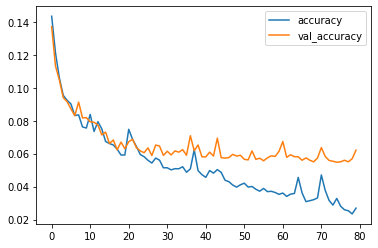

frames:60.0, accuracy:66.667


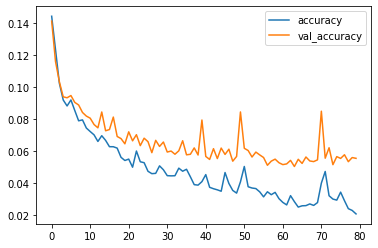

In [40]:
for i in range(len(df)):
    print(f'frames:{df.iloc[i].frames}, accuracy:{df.iloc[i].accuracy:.3f}')
    plt.plot(list(range(0, len(train_losses_list[i]))), train_losses_list[i],label = 'accuracy')
    plt.plot(list(range(0, len(valid_losses_list[i]))), valid_losses_list[i], label = 'val_accuracy')
    plt.legend()
    plt.show()